In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [10]:
def FtoC(T):
    return (T-32)*5/9

def func(x,a0,a1,a2,m,Tin):
    return ((a1+a2*(Tin-x)/np.log(Tin/x)/10))-m*a0*(Tin-x)

def iceStorage(mode,Tin,m,ice_inv_s,totalTime = [],tariff = 0.0876):
#     This function is used to simulate the performance of ice storage tank at
#     IBAL in both charging and discharging mode.
#     Governing equation of discharging mode is Gregor Henze's ice storage tank
#     model.
#     Governing equation of charging mode is Galler's ice storage tank with
#     constatnt charging rate.

#     Inputs of this function:
#       mode:
#           0: discharge
#           1: charge by chiller 1
#           2: charge by chiller 2
#       Tin: ice tank inlet water temperature in C
#       m: flow rate through ice storage tank in kg/s
#       ice_inv_s: ice inventory at the start of each time step. Range: 0-1 (0 to 100 %).
#       totalTime: total time that the mode is being used. If empty, then just run until the inventory is
#                  zero (mode = 0) or 0.85 (mode = 1 or 2). Units are s.
#       tariff: cost of electricity in $/kWh

#     Output of this function:
#       Tout: ice tank outlet water temperature in C
#       ice_inv_e: ice inventory at the end of each time step. Range: 0-1 (0 to 100 %).
#       time: the time to fully charge the tank, fully discharge the tank, or the time you put as an input if it is less
#             than the charge/discharge time; units are hr
#       inv: change in inventory at each time step. Range 0-1 (0 to 100 %)
#       ToutL: ice tank outlet water temperature in C at each time step
#       cost: cost to charge the ice tank in $

#     Parameters of this function:
#       C1,C2,C3,C4,C5,C6: Gregor Henze model constants for discharging: 
#       time_step: time step of the simulation, in seconds.
#       CR_Chiller1: charging rate of chilelr 1; CR_Chiller2: charging rate of
#       chiller 2

    # Parameters, trained by discharging experiment in 5/9/2018,5/14/2018, 5/17/2018 
    C1 = 5.54E-05
    C2 = -0.000145679
    C3 = 9.28E-05
    C4 = 0.001126122
    C5 = -0.0011012
    C6 = 0.000300544
    time_step = 10 # 10 second time step used
    # if the user doesn't pass in a total time, just use a large enough time to complete whatever
    # process is being used
    # Set the number of timesteps
    if not totalTime:
        nSteps = 100000 
    else:
        nSteps = int(round(totalTime/time_step)) 
    # Charge rate for each chiller in kW
    CR_Chiller1 = 14
    CR_Chiller2 = 17
    # Initialize values
    ToutL = []
    inv = []
    timeVec = []
    it = 1 # Used to prevent an infinite loop
    notDone = 1 # Used to stop the loop
    time = time_step
    # Loop over the calculation until notDone = 0 
    # Each iteration is one time step. The model constants were based on data with a time step of 10 s,
    # so each iteration is 10 s in real time.
    while ((notDone == 1)):
        a0 = 3.915*time_step/(334*2846.35)
        a1 = C1 + C2*(1 - ice_inv_s) + C3*(1 - ice_inv_s)*(1 - ice_inv_s)
        a2 = C4 + C5*(1 - ice_inv_s) + C6*(1 - ice_inv_s)*(1 - ice_inv_s)
        
        #Mode 0, Discharging mode
        if mode == 0:
            #Calculate Tout
            lb = 0.1 # lower bound for bisection method
            ub = Tin - 0.1 # upper bound for bisection method
            # Temperature out of the ice tank
            Tout = optimize.bisect(func, lb, ub, args = (a0,a1,a2,m,Tin))                      
            # Calculate ice_inv_e   
            # change in inventory in one time step
            deltat =  - (3.915 * m * time_step * (-Tout + Tin))/(334*2846.35)
            # ice inventory at the end of one time step
            ice_inv_e = ice_inv_s - (3.915 * m * time_step * (-Tout + Tin))/(334*2846.35) 
            # if the ice inventory is essentially 0, then you're done; stop the loop
            if ice_inv_e <= 0:
                notDone = 0
            else:
                notDone = 1
        elif mode == 1:
        # When charging by chiller 1, charging rate is 14.61 kW according to
        # 7/5/2017 Experiment
            # Temperature out of the ice tank
            Tout = CR_Chiller1 / (3.915 * m) + Tin
            # Calculate ice_inv_e   
            # change in inventory in one time step
            deltat =  - (3.915 * m * time_step * (-Tout + Tin))/(334*2846.35) 
            # ice inventory at the end of one time step
            ice_inv_e = ice_inv_s - (3.915 * m * time_step * (-Tout + Tin))/(334*2846.35)
            # if the ice inventory is essentially 1, then you're done; stop the loop
            if ice_inv_e >= 1:
                notDone = 0
            else:
                notDone = 1
        else:
        # When charging by chiller 2, average charging rate is 18.97 kW according to
        # 2/1/2017, 5/22/2017 Experiment    
            # Temperature out of the ice tank
            Tout = CR_Chiller2 / (3.915 * m) + Tin
            # Calculate ice_inv_e   
            # change in inventory in one time step
            deltat =  - (3.915 * m * time_step * (-Tout + Tin))/(334*2846.35) 
            # ice inventory at the end of one time step
            ice_inv_e = ice_inv_s - (3.915 * m * time_step * (-Tout + Tin))/(334*2846.35)
            # if the ice inventory is essentially 1, then you're done; stop the loop
            if ice_inv_e >= 1:
                notDone = 0
            else:
                notDone = 1

        # limit the ice inventory to be between 0 and 1
        ice_inv_e = max(0,min(1,ice_inv_e))
        # Set the ice inventory for the next iteration
        ice_inv_s = ice_inv_e
        # Store results
        inv.append(ice_inv_e)
        ToutL.append(Tout)
        # If the loop is not done, increment the time and the iteration
        if notDone == 1:
            time = time + time_step
            timeVec.append(it*time_step/3600) # time vector in hours
            it = it + 1  
        # If the number of iterations exceeds nSteps, stop the loop even if notDone == 1
        if it > nSteps:
            notDone = 0
            timeVec.append(it*time_step/3600) # time vector in hours
    # Estimate the cost of operating the ice tank
    if mode == 0:
        # for a worst case cost, assume that you had to use Chiller2 to recharge the ice tank
        dInv = 10*CR_Chiller2/(334*2846.35) # change in inventory with each timestep in charging
        nInv = abs(ice_inv_e-inv[0]) # total change in inventory
        dt = nInv/dInv*10 # time to recharge the inventory
        # time is in seconds, so convert to hours and multiply by $/kWh
        cost = dt/3600*CR_Chiller2*tariff   
    elif mode == 1:
        # time is in seconds, so convert to hours and multiply by $/kWh
        cost = time/3600*CR_Chiller1*tariff  
    else:
        # time is in seconds, so convert to hours and multiply by $/kWh
        cost = time/3600*CR_Chiller2*tariff  
    timeVec.append(time/3600)
    return ice_inv_e,Tout,time/3600,inv,ToutL,timeVec,cost

<IPython.core.display.Javascript object>


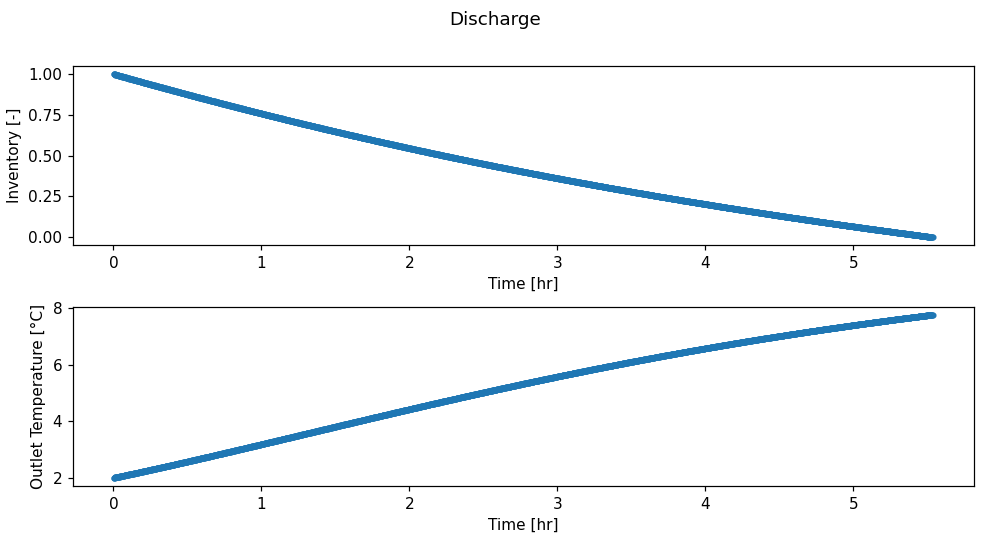

In [14]:
%matplotlib notebook
iceInvEnd,Tout,time,inv,ToutL,timeVec,cost = iceStorage(0,FtoC(55),1.6,1)
fig, ax = plt.subplots(2,1,figsize = [9,5])
ax[0].plot(timeVec,inv,'.')
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Inventory [-]')
ax[1].plot(timeVec,ToutL,'.')
ax[1].set_xlabel('Time [hr]')
ax[1].set_ylabel('Outlet Temperature [°C]')
fig.suptitle('Discharge')
fig.tight_layout()
fig.subplots_adjust(top=0.88)

<IPython.core.display.Javascript object>


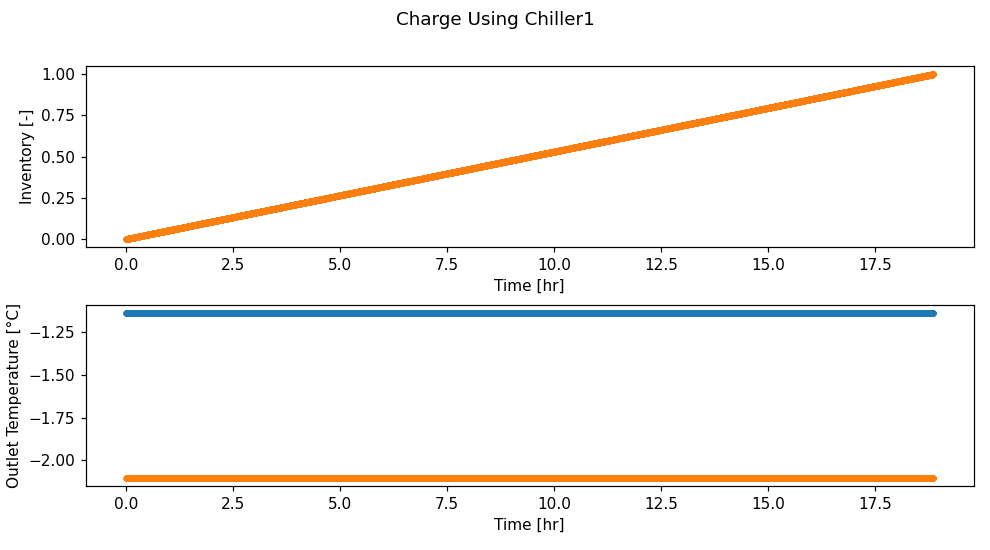

In [20]:
iceInvEnd,Tout,time,inv,ToutL,timeVec,cost = iceStorage(1,FtoC(25),1.3,0)
fig, ax = plt.subplots(2,1,figsize = [9,5])
ax[0].plot(timeVec,inv,'.')
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Inventory [-]')
ax[1].plot(timeVec,ToutL,'.')
ax[1].set_xlabel('Time [hr]')
ax[1].set_ylabel('Outlet Temperature [°C]')

fig.suptitle('Charge Using Chiller1')
fig.tight_layout()
fig.subplots_adjust(top=0.88)

<IPython.core.display.Javascript object>


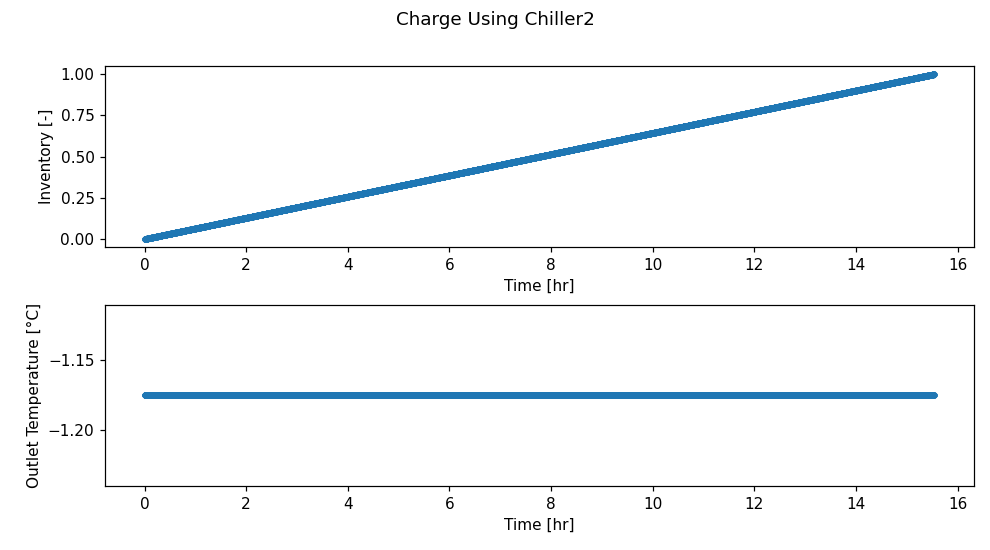

In [17]:
iceInvEnd,Tout,time,inv,ToutL,timeVec,cost = iceStorage(2,FtoC(25),1.6,0)
fig, ax = plt.subplots(2,1,figsize = [9,5])
ax[0].plot(timeVec,inv,'.')
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Inventory [-]')
ax[1].plot(timeVec,ToutL,'.')
ax[1].set_xlabel('Time [hr]')
ax[1].set_ylabel('Outlet Temperature [°C]')
fig.suptitle('Charge Using Chiller2')
fig.tight_layout()
fig.subplots_adjust(top=0.88)